In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

# 앙상블학습 : 보팅(voting)

- 여러 예측기(estimator)의 결과들을 투표를 통해 최종 예측 결과로 결정하는 방식
- 일반적으로 서로 다른 알고리즘을 가진 예측기(estimator)를 결합

### 사이킷런의 보팅 분류기

In [ ]:
from sklearn.ensemble import VotingClassifier

In [4]:
VotingClassifier

Object `VotingClassifier` not found.


sklearn.ensemble.VotingClassifier
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

- estimators : 리스트 값으로 보팅에 사용될 여러 개의 Classifier 객체
    - 모델이름과 객체명을 튜플로 구성한 리스트로 지정
    - 예. [('LR', lr_clf),('KNN', knn_clf)]
        - LinearRegression 객체 lr_clf의 이름을 'LR'
        - KNN 객체 knn_clf 이름을 'KNN'으로 지정
        
    
- voting : 보팅 방식 hard/soft(디폴트 : hard) 

## 실습. 유방암 악성/양성 종양 분류 예측

### 위스콘신 유방암 데이터

- **`sklearn.datasets.load_breast_cancer()`**
- 유방암의 악성종양, 양성종양 여부를 결정하는 이진 분류 데이터 세트
- 종양의 크기, 모양 등의 형태와 관련한 많은 피처 포함

In [5]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [6]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer Wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [7]:
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

#### 관련 모듈 임포트

In [12]:
cancer.target_names
#malignant : 악성 benign 양성

array(['malignant', 'benign'], dtype='<U9')

### 보팅 분류기(Voting Classifier) 생성

- 로지스틱 회귀와 KNN 기반의 소프트 보팅 방식으로 보팅 분류기 생성

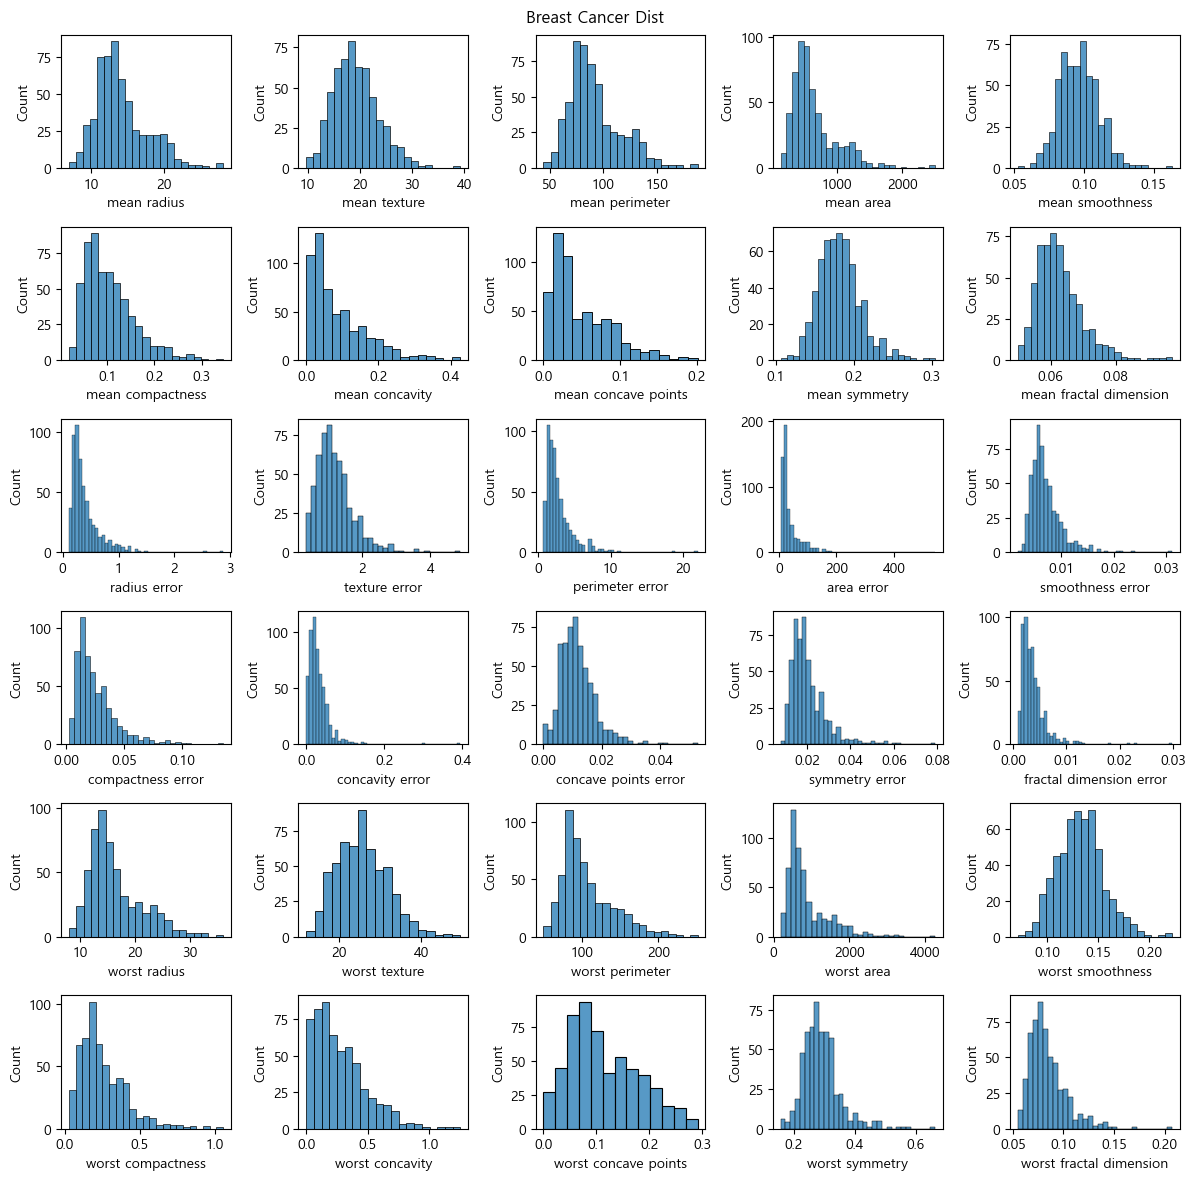

In [20]:
nrows, ncols= 6, 5
fig,axs=plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12))
for i, ftr in enumerate(cancer.feature_names):
    rows, col = i//ncols, i %ncols
    sns.histplot(cancer_df[ftr], ax=axs[rows][col])
plt.suptitle('Breast Cancer Dist')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [26]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
estimators=[('LR',lr_clf),('KNN',knn_clf)]
vo_clf = VotingClassifier(estimators=estimators, voting='soft')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=2020158011)

In [32]:
import sys
sys.path.append('mymodule')
from mymodule.evals import print_eval_score, show_confusion_matrix

In [37]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
pred_proba = vo_clf.predict_proba(X_test)[:,1]
print_eval_score(y_test, pred, pred_proba, target_names=cancer.target_names)

accuracy : 0.9123, recall : 0.9359, precision : 0.9359
f1: 0.9359, g-measure: 0.9359


In [38]:
print_eval_score(y_test, pred, pred_proba, target_names=cancer.target_names)

accuracy : 0.9123, recall : 0.9359, precision : 0.9359
f1: 0.9359, g-measure: 0.9359


#### VotingClassifier 생성

- 개별모델은 로지스틱 회귀와 KNN
- 소프트보팅 방식

In [42]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
estimators=[('LR',lr_clf),('KNN',knn_clf)]
vo_clf_hard = VotingClassifier(estimators=estimators, voting='hard')

#### Split Dataset 

In [46]:
vo_clf_hard.fit(X_train, y_train)
pred = vo_clf_hard.predict(X_test)
print_eval_score(y_test, pred, target_names=cancer.target_names)

accuracy : 0.9035, recall : 0.8846, precision : 0.9718
f1: 0.9262, g-measure: 0.9272


#### VotingClassifier 학습/예측/평가

In [49]:
clf_list= [lr_clf, knn_clf]
for clf in clf_list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:,1]
    print(f'## {clf.__class__.__name__} 예측 성능')
    print_eval_score(y_test, y_pred, y_pred_proba, target_names=cancer.target_names)
    print('---------------------------------')

## LogisticRegression 예측 성능
accuracy : 0.9035, recall : 0.8974, precision : 0.9589
f1: 0.9272, g-measure: 0.9277
---------------------------------
## KNeighborsClassifier 예측 성능
accuracy : 0.9298, recall : 0.9487, precision : 0.9487
f1: 0.9487, g-measure: 0.9487
---------------------------------


#### 참고. 개별 모델별 학습/예측/평가

-------------------------------------------------